### This notebook solves a Customer Churn Prediction Problem using 3 types of algorithms, using different transformations of the original dataset to better suit each algorithm.The algorithms used are:
### 1) SVM
### 2) Decision Tree
### 3) Random Forests

In [1]:
#import the required libraries:
import pandas as pd
import io
import matplotlib.pyplot as plt
import os
import requests
import numpy as np
from IPython.display import display, HTML
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import  cross_val_score, cross_val_predict, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import graphviz as g
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier #classification tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix

#import time



url = "https://s3.amazonaws.com/orim-misc-data/assessment/subscribers.csv"
webpage =requests.get(url).content
df =pd.read_csv(io.StringIO(webpage.decode('utf-8')))
print (df.head())



C:\Users\froze\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


                 Profile.Id         Domain  Engagement               Signup  \
0  5572fb5592721912198b587b  sbcglobal.net  hardbounce  2015/06/06 09:53:25   
1  5441111b66dfa5ab01b0a000    hotmail.com      optout  2014/10/17 08:52:43   
2  56cde9d9d9cb94486d8b51d7      yahoo.com      optout  2016/02/24 12:35:21   
3  57e68298d9cb942a708b48db      gmail.com     dormant  2016/09/24 09:41:44   
4  5498bd77f641910f100e23fb  sbcglobal.net      optout  2014/12/22 19:55:19   

   Opens  Clicks            Last.Open           Last.Click  \
0     51      11  2016/01/20 00:35:25  2015/08/12 19:50:19   
1      2       0  2014/11/21 07:37:15                  NaN   
2      0       0                  NaN                  NaN   
3      0       0                  NaN                  NaN   
4     30       1  2015/01/06 21:10:26  2015/01/01 21:21:20   

           Optout.Time        Geolocation.City  ... Geolocation.Country  \
0                  NaN  El Dorado Hills, CA US  ...                  US   
1 

# Support Vector Machine
## Data Cleaning and Transformation


In [2]:
#create a copy of the the two columns needed into a new Dataframe df1
df1 = df[['referral_source','Signup']].copy()
print (df1.head(10))

  referral_source               Signup
0             DMi  2015/06/06 09:53:25
1        Untagged  2014/10/17 08:52:43
2             DMi  2016/02/24 12:35:21
3        Facebook  2016/09/24 09:41:44
4             NaN  2014/12/22 19:55:19
5      In Book Ad  2016/10/07 21:45:30
6      LiveIntent  2016/05/20 10:42:54
7             DMi  2015/09/14 12:53:41
8        Untagged  2014/10/01 19:15:03
9        Facebook  2014/11/23 15:16:35


In [3]:
#now that a new dataframe has been created we can preprocess it for our usage
#convert the data type of the Date from object to datetime64: 
df1['Signup']= pd.to_datetime(df1['Signup'], format ='%Y-%m-%d')
print (df1.head(10))
print (df1.dtypes)

  referral_source              Signup
0             DMi 2015-06-06 09:53:25
1        Untagged 2014-10-17 08:52:43
2             DMi 2016-02-24 12:35:21
3        Facebook 2016-09-24 09:41:44
4             NaN 2014-12-22 19:55:19
5      In Book Ad 2016-10-07 21:45:30
6      LiveIntent 2016-05-20 10:42:54
7             DMi 2015-09-14 12:53:41
8        Untagged 2014-10-01 19:15:03
9        Facebook 2014-11-23 15:16:35
referral_source            object
Signup             datetime64[ns]
dtype: object


In [4]:
#Gather info about the Dataframe:
print (df1.describe())

       referral_source               Signup
count           630008               705144
unique              75               593820
top                DMi  2017-04-07 15:45:49
freq            243435                 1443
first              NaN  2014-06-16 15:14:30
last               NaN  2017-04-20 00:57:58


In [5]:
#Rename the columns 
df1.rename(columns={'referral_source':'Source','Signup':'Signup_Date'}, inplace =True)
df1['Signup_Date']=df1['Signup_Date'].dt.normalize()         #normalize the column to remove the timestamp from displaying without changing the dtype
df1.head()


,Source,Signup_Date
0,DMi,2015-06-06
1,Untagged,2014-10-17
2,DMi,2016-02-24
3,Facebook,2016-09-24
4,NaN,2014-12-22


In [6]:
#preprocess the data before we can make the binary columns for the column ebb_preferences:

df_preferences =df['ebb_preferences']

print (df_preferences.head(5))

0    ["bestsellers","mysteries_thrillers_true_crime...
1                                                  NaN
2                                                  NaN
3                    ["bestsellers","book_club_picks"]
4                                                  NaN
Name: ebb_preferences, dtype: object


In [7]:
#replace the missing value with "All"
df_preferences=df_preferences.replace(np.nan,'["All Genres"]')
df_preferences.columns =["ebb_preferences"]
print (df_preferences.head(5))
print (df_preferences.dtype)


0    ["bestsellers","mysteries_thrillers_true_crime...
1                                       ["All Genres"]
2                                       ["All Genres"]
3                    ["bestsellers","book_club_picks"]
4                                       ["All Genres"]
Name: ebb_preferences, dtype: object
object


In [8]:
#DATA CLEANING:
#convert to lower case:
df_preferences=df_preferences.str.lower()
#df_pre

#nltk to remove stopwords from the DataFrame:
from nltk.corpus import stopwords
stop_words =stopwords.words('english')

df_preferences=df_preferences.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [9]:
##used this to convert everthing as strings
import json
df_preferences.to_json()
#df_pre


#used this to change the strings to list. 
L_preferences=df_preferences.apply(lambda x: x[1:-1].split(','))

#count the longest list and elements within that list for EXPLORATION:
maxlist =max(L_preferences, key =len)
maxlength = max(map(len, L_preferences))

print (maxlist, maxlength)



['"bestsellers"', '"book_club_picks"', '"biographies_and_memoir"', '"childrens"', '"general_nonfiction"', '"historical_fiction"', '"history"', '"lifestyle_and_cooking"', '"literary_fiction"', '"mysteries_thrillers_true_crime"', '"poetry"', '"romance"', '"science_fiction_fantasy"', '"young_adult"', '"bestsellers"', '"book_club_picks"'] 16


In [10]:
#cleaning lists in list from punctuation and removing words with len<3:
import string
cleaned_list=[]

for x in L_preferences:
    x=[''.join(c for c in s if c not in string.punctuation) for s in x]
    
    #removing words that are less than 3:
    x=[word for word in x if len(word) >3]
    cleaned_list.append(x)
cleaned_list[:20]



    
        

[['bestsellers',
  'mysteriesthrillerstruecrime',
  'sciencefictionfantasy',
  'literaryfiction',
  'generalnonfiction'],
 ['all genres'],
 ['all genres'],
 ['bestsellers', 'bookclubpicks'],
 ['all genres'],
 ['historicalfiction',
  'literaryfiction',
  'mysteriesthrillerstruecrime',
  'romance',
  'youngadult',
  'biographiesandmemoir',
  'lifestyleandcooking',
  'bestsellers',
  'bookclubpicks'],
 ['childrens',
  'historicalfiction',
  'literaryfiction',
  'sciencefictionfantasy',
  'youngadult',
  'biographiesandmemoir',
  'generalnonfiction',
  'history',
  'lifestyleandcooking',
  'poetry',
  'bestsellers',
  'bookclubpicks'],
 ['biographiesandmemoir'],
 ['all genres'],
 ['all genres'],
 ['historicalfiction',
  'literaryfiction',
  'mysteriesthrillerstruecrime',
  'sciencefictionfantasy',
  'youngadult',
  'generalnonfiction',
  'history',
  'lifestyleandcooking',
  'bestsellers',
  'bookclubpicks'],
 ['historicalfiction',
  'literaryfiction',
  'mysteriesthrillerstruecrime',
  'b

In [11]:
df.head(50)

,Profile.Id,Domain,Engagement,Signup,Opens,Clicks,Last.Open,Last.Click,Optout.Time,Geolocation.City,...,Geolocation.Country,Geolocation.Zip,Lifetime.Message,Top.Device,referral_source,first_name,last_name,age,gender,ebb_preferences
0,5572fb5592721912198b587b,sbcglobal.net,hardbounce,2015/06/06 09:53:25,51,11,2016/01/20 00:35:25,2015/08/12 19:50:19,NaN,"El Dorado Hills, CA US",...,US,95762 US,169,Other,DMi,Betty,Goodwin,NaN,NaN,"[""bestsellers"",""mysteries_thrillers_true_crime..."
1,5441111b66dfa5ab01b0a000,hotmail.com,optout,2014/10/17 08:52:43,2,0,2014/11/21 07:37:15,NaN,2014/11/21 07:45:29,NaN,...,NaN,NaN,203,NaN,Untagged,NaN,NaN,NaN,NaN,NaN
2,56cde9d9d9cb94486d8b51d7,yahoo.com,optout,2016/02/24 12:35:21,0,0,NaN,NaN,2016/03/02 19:45:14,NaN,...,NaN,NaN,10,NaN,DMi,Ana,Alvarez,NaN,NaN,NaN
3,57e68298d9cb942a708b48db,gmail.com,dormant,2016/09/24 09:41:44,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,257,NaN,Facebook,NaN,NaN,NaN,NaN,"[""bestsellers"",""book_club_picks""]"
4,5498bd77f641910f100e23fb,sbcglobal.net,optout,2014/12/22 19:55:19,30,1,2015/01/06 21:10:26,2015/01/01 21:21:20,2015/01/06 21:11:33,NaN,...,US,NaN,39,Android,NaN,NaN,NaN,NaN,NaN,NaN
5,57f84fbad9cb94f1778b50d7,hotmail.com,passive,2016/10/07 21:45:30,54,29,2017/04/17 15:29:19,2017/04/06 10:34:26,NaN,"Birmingham, MI US",...,US,48009 US,235,Chrome,In Book Ad,NaN,NaN,NaN,NaN,"[""historical_fiction"",""literary_fiction"",""myst..."
6,573f226e72fbf2aa4c8b4d15,yahoo.com,optout,2016/05/20 10:42:54,16,0,2016/05/25 20:24:56,NaN,2016/05/25 20:26:02,NaN,...,NaN,NaN,9,NaN,LiveIntent,NaN,NaN,NaN,NaN,"[""childrens"",""historical_fiction"",""literary_fi..."
7,55f6fb9527fdb0b27e8b4827,gmail.com,disengaged,2015/09/14 12:53:41,16,0,2017/02/05 20:51:11,NaN,NaN,NaN,...,NaN,NaN,632,NaN,DMi,Rose,DosSantos,NaN,NaN,"[""biographies_and_memoir""]"
8,542c8af71939acb4378b4583,hotmsil.com,hardbounce,2014/10/01 19:15:03,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,1,NaN,Untagged,NaN,NaN,NaN,NaN,NaN
9,547240a366dfa5cb6616a667,yahoo.com,hardbounce,2014/11/23 15:16:35,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,1,NaN,Facebook,NaN,NaN,NaN,NaN,NaN


In [12]:
##remove repeated Genres from the same lists:
pref_list=[]
for l in cleaned_list:
    new_l=list(set(l))
    pref_list.append(new_l)
print (pref_list[:50])



[['mysteriesthrillerstruecrime', 'generalnonfiction', 'bestsellers', 'literaryfiction', 'sciencefictionfantasy'], ['all genres'], ['all genres'], ['bookclubpicks', 'bestsellers'], ['all genres'], ['mysteriesthrillerstruecrime', 'bestsellers', 'biographiesandmemoir', 'literaryfiction', 'historicalfiction', 'youngadult', 'romance', 'lifestyleandcooking', 'bookclubpicks'], ['generalnonfiction', 'bestsellers', 'biographiesandmemoir', 'literaryfiction', 'sciencefictionfantasy', 'historicalfiction', 'childrens', 'youngadult', 'history', 'poetry', 'lifestyleandcooking', 'bookclubpicks'], ['biographiesandmemoir'], ['all genres'], ['all genres'], ['mysteriesthrillerstruecrime', 'generalnonfiction', 'bestsellers', 'literaryfiction', 'sciencefictionfantasy', 'historicalfiction', 'youngadult', 'history', 'lifestyleandcooking', 'bookclubpicks'], ['mysteriesthrillerstruecrime', 'generalnonfiction', 'bestsellers', 'biographiesandmemoir', 'literaryfiction', 'historicalfiction', 'history', 'bookclubpic

In [13]:
df.head()

,Profile.Id,Domain,Engagement,Signup,Opens,Clicks,Last.Open,Last.Click,Optout.Time,Geolocation.City,...,Geolocation.Country,Geolocation.Zip,Lifetime.Message,Top.Device,referral_source,first_name,last_name,age,gender,ebb_preferences
0,5572fb5592721912198b587b,sbcglobal.net,hardbounce,2015/06/06 09:53:25,51,11,2016/01/20 00:35:25,2015/08/12 19:50:19,NaN,"El Dorado Hills, CA US",...,US,95762 US,169,Other,DMi,Betty,Goodwin,NaN,NaN,"[""bestsellers"",""mysteries_thrillers_true_crime..."
1,5441111b66dfa5ab01b0a000,hotmail.com,optout,2014/10/17 08:52:43,2,0,2014/11/21 07:37:15,NaN,2014/11/21 07:45:29,NaN,...,NaN,NaN,203,NaN,Untagged,NaN,NaN,NaN,NaN,NaN
2,56cde9d9d9cb94486d8b51d7,yahoo.com,optout,2016/02/24 12:35:21,0,0,NaN,NaN,2016/03/02 19:45:14,NaN,...,NaN,NaN,10,NaN,DMi,Ana,Alvarez,NaN,NaN,NaN
3,57e68298d9cb942a708b48db,gmail.com,dormant,2016/09/24 09:41:44,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,257,NaN,Facebook,NaN,NaN,NaN,NaN,"[""bestsellers"",""book_club_picks""]"
4,5498bd77f641910f100e23fb,sbcglobal.net,optout,2014/12/22 19:55:19,30,1,2015/01/06 21:10:26,2015/01/01 21:21:20,2015/01/06 21:11:33,NaN,...,US,NaN,39,Android,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
#Replace all engagements that aren't opt-out with subscribed
df['Engagement'] = df['Engagement'].replace(['disengaged','active','hardbounce','engaged','new','passive','dormant'], 'subscribed')
print(df['Engagement'])


0         subscribed
1             optout
2             optout
3         subscribed
4             optout
             ...    
705139    subscribed
705140    subscribed
705141    subscribed
705142    subscribed
705143    subscribed
Name: Engagement, Length: 705144, dtype: object


In [16]:
new_df = df.join(df1)

In [17]:
#encode none int parameters
def encode_target(df, target_column):
    """Add column to df with integers for the target.

    Args
    ----
    df -- pandas Data Frame.
    target_column -- column to map to int, producing new
                     Target column.

    Returns
    -------
    df -- modified Data Frame.
    targets -- list of target names.
    """
    df_mod = df.copy()
    targets = df_mod[target_column].unique()
    map_to_int = {name: n for n, name in enumerate(targets)}
    df_mod[target_column+"Enc"] = df_mod[target_column].replace(map_to_int)

    return (df_mod, targets)

new_df, targets = encode_target(new_df, "Engagement")
new_df, targets = encode_target(new_df, "Top.Device")

In [18]:
#Create X and Y data
features = ["Opens","Clicks","Lifetime.Message","Top.DeviceEnc"]
X = new_df[features]
X = X.join(df1['Signup_Date'].dt.year)
#X = X.join(df1['SourceEnc'])
X = X.join(df['ebb_preferences'])
#X = X.join(pd.DataFrame(mlb.fit_transform(series_pref),columns=mlb.classes_))
#print(X)
Y = new_df["EngagementEnc"]


In [19]:
X

,Opens,Clicks,Lifetime.Message,Top.DeviceEnc,Signup_Date,ebb_preferences
0,51,11,169,0,2015,"[""bestsellers"",""mysteries_thrillers_true_crime..."
1,2,0,203,1,2014,NaN
2,0,0,10,1,2016,NaN
3,0,0,257,1,2016,"[""bestsellers"",""book_club_picks""]"
4,30,1,39,2,2014,NaN
...,...,...,...,...,...,...
705139,11,0,647,1,2015,"[""childrens""]"
705140,11,1,606,6,2015,"[""literary_fiction"",""mysteries_thrillers_true_..."
705141,17,0,634,1,2015,"[""bestsellers"",""lifestyle_and_cooking"",""myster..."
705142,225,15,401,5,2016,"[""childrens"",""literary_fiction"",""mysteries_thr..."


In [20]:
# OneHotEncoding for Signup_Data column
datesOHE = pd.get_dummies(X['Signup_Date'])
X = X.join(datesOHE)
X.drop('Signup_Date',axis=1,inplace=True) 


In [21]:
# OneHotEncoding for Signup_Data column
TopDOHE = pd.get_dummies(X['Top.DeviceEnc'])
X = X.join(TopDOHE)
X.drop('Top.DeviceEnc',axis =1,inplace = True)

In [23]:
count_list =[]
for item in pref_list:
    count_list.append(len(item))
X['ebb_preferences'] = count_list
X

,Opens,Clicks,Lifetime.Message,ebb_preferences,2014,2015,2016,2017,0,1,...,13,14,15,16,17,18,19,20,21,22
0,51,11,169,5,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,203,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,10,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,257,2,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,30,1,39,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705139,11,0,647,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
705140,11,1,606,4,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
705141,17,0,634,5,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
705142,225,15,401,13,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
numerical_features = ['Opens', 'Clicks', 'Lifetime.Message', "ebb_preferences"]
target = 'EngagementEnc'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000197724D35C8>,
      dtype=object)

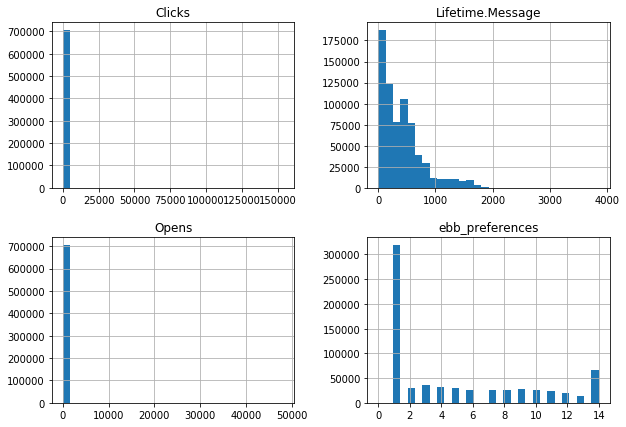

In [25]:
X[numerical_features].hist(bins=30, figsize=(10, 7))

In [26]:
# split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [22]:
# custom accuracy function 
def accuracy(ydata,yPred):
    totalSub = 0
    totalOpt = 0
    subCorrect = 0
    optCorrect = 0
    l = len(ydata)
    y = ydata.to_numpy()
    for i in range(l):
        if y[i] == 0:
            totalSub+= 1
        else:
            totalOpt+= 1
        if y[i] == yPred[i]:
            if y[i] == 0:
                subCorrect+= 1
            else:
                optCorrect+= 1
    percentSubPred = subCorrect/totalSub
    percentOptPred = optCorrect/totalOpt
    total = totalSub+totalOpt
    #print(total)
    correct = subCorrect+optCorrect
    #print(correct)
    misclass = total-correct
    #print(misclass)
    
    return(percentOptPred, percentSubPred, misclass)  

## Training and Testing the SVC Models
### Two types of SVC are tested: 
### 1) LinearSVC with different parameters
### 2) RBF Kernel Approximator + Stochastic Gradient Descent with different parameters
### The second model is almost equivalent to an SVC with an RBF Kernel

In [38]:
#LinearSVC
# Without SourceEnc and no Parameters Set: Test Opt-Out Percent Correct: 0.607 Test Subscribed Percent Correct: 0.87
#Parameters:  fit_intercept = False: Optout Accuracy : 0.4236, subscribed accuracy: 0.9568
#             fit_intercept = False,dual =False,class_weight = balanced: Optout Accuracy: 0.773, subscribed accuracy: 0.851
#             dual =False,class_weight = balanced: Optout Accuracy: 0.7724, subsribed accuracy: 0.851
#             C = 3.0, max_iter = 2000: Optout : 0.54, subscribed = 0.92
        
from sklearn import svm
from sklearn.svm import SVC 
clf = svm.LinearSVC(fit_intercept = False,dual = False,class_weight = 'balanced')
clf.fit(X_train,Y_train)
yPredTrain = clf.predict(X_train)
yPredTest = clf.predict(X_test)
trainOptAcc, trainSubAcc, trainMisclass = accuracy(Y_train, yPredTrain)
testOptAcc, testSubAcc, testMisclass = accuracy(Y_test, yPredTest)

print("Training Opt-out Percent Correct: ",trainOptAcc*100, "\nTraining Subscribed Percent Correct: ", trainSubAcc*100)
print("Test Opt-out Percent Correct: ",testOptAcc*100, "\nTest Subscribed Percent Correct: ", testSubAcc*100, "\nTest Misclassifications: ", testMisclass)

Training Opt-out Percent Correct:  77.44594387363901 
Training Subscribed Percent Correct:  85.0011013822347
Test Opt-out Percent Correct:  77.28537325220326 
Test Subscribed Percent Correct:  85.0934666401422 
Test Misclassifications:  35884


In [39]:
# RBF+SGD
# No Parameters Set: Test Opt-Out Percent Correct: 51% Test Subscribed Percent Correct: 55%
# Parameters:  RBFsampler gamma = 0.1: Optout Accuracy : 53%, subscribed accuracy: 62%
#              RBFsampler gamma = 0.3: Optout Accuracy: 49%, subscribed accuracy: 61%
# default      RBFsampler gamma = 1.0: Optout Accuracy: 51%, subscribed accuracy: 55%
#              RBFsampler gamma = 3.0: Optout Accuracy: 48%, subscribed accuracy: 58%
#              SGDClassifier alpha =0.001,max_iter = 2000: optout accuracy: 46%,subscriber accuracy: 60%
#              Best: gamma = 0.1(RBF), max_iter =1000 and class_weight = balanced(SGD) (Without SourceEnc column)
#              Best Accuracy: Optout: 53%  Subsribed: 62%
from sklearn import svm
from sklearn.svm import SVC 
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
rbf_feature = RBFSampler(gamma= 0.1, random_state=1)
X_features = rbf_feature.fit_transform(X_train)
X_fit = rbf_feature.fit_transform(X_test)
sgd = SGDClassifier(max_iter=1000, class_weight = 'balanced')
sgd.fit(X_features, Y_train)
yPredTrain = sgd.predict(X_features)
yPredTest = sgd.predict(X_fit)
trainOptAcc, trainSubAcc, trainMisclass = accuracy(Y_train, yPredTrain)
testOptAcc, testSubAcc, testMisclass = accuracy(Y_test, yPredTest)
print("Training Opt-out Percent Correct: ",trainOptAcc*100, "\nTraining Subscribed Percent Correct: ", trainSubAcc*100,"\t")
print("Test Opt-out Percent Correct: ",testOptAcc*100, "\nTest Subscribed Percent Correct: ", testSubAcc*100, "\nTest Misclassifications: ", testMisclass)


Training Opt-out Percent Correct:  57.36083422787917 
Training Subscribed Percent Correct:  58.460267635883035 	
Test Opt-out Percent Correct:  57.13567748999336 
Test Subscribed Percent Correct:  58.4273989129249 
Test Misclassifications:  88664


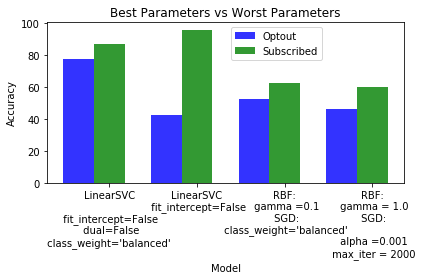

In [30]:
# data to plot
n_groups = 4
means_optout = (77.29, 42.36, 52.78, 46)
means_subscribed = (87.09, 95.68, 62.23, 60)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_optout, bar_width,
alpha=opacity,
color='b',
label='Optout')

rects2 = plt.bar(index + bar_width, means_subscribed, bar_width,
alpha=opacity,
color='g',
label='Subscribed')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Best Parameters vs Worst Parameters')
plt.xticks(index + bar_width, ("LinearSVC\n \n fit_intercept=False\n dual=False\n class_weight='balanced' ", 
                               "LinearSVC\n fit_intercept=False",
                               "RBF:\n gamma =0.1\n SGD:\n class_weight='balanced'",
                               "RBF:\n gamma = 1.0\n SGD:\n \n alpha =0.001\n max_iter = 2000"))
plt.legend(loc='upper left', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))

plt.tight_layout()
plt.show()


# Random Forests
## Data Cleaning and Trasformation

In [40]:
df_randfor= df
df_randfor=df_randfor.fillna(0)

In [41]:
# Extract year from Signup column
df_randfor['Signup']= pd.to_datetime(df_randfor['Signup'], format ='%Y-%m-%d')
df_randfor['Signup']=df_randfor['Signup'].dt.normalize() 
df_randfor['Signup']=df_randfor['Signup'].dt.year
print (df_randfor['Signup'])


0         2015
1         2014
2         2016
3         2016
4         2014
          ... 
705139    2015
705140    2015
705141    2015
705142    2016
705143    2015
Name: Signup, Length: 705144, dtype: int64


In [42]:
# Extract year from Last.Open column
df_randfor['Last.Open']= pd.to_datetime(df_randfor['Last.Open'], format ='%Y-%m-%d')
df_randfor['Last.Open']=df_randfor['Last.Open'].dt.normalize() 
df_randfor['Last.Open']=df_randfor['Last.Open'].dt.year
df_randfor['Last.Open']=df_randfor['Last.Open'].astype(int)
print (df_randfor['Last.Open'])

0         2016
1         2014
2         1970
3         1970
4         2015
          ... 
705139    2017
705140    2017
705141    2017
705142    2017
705143    2017
Name: Last.Open, Length: 705144, dtype: int32


In [43]:
# Extract year from Last.Click column
df_randfor['Last.Click']= pd.to_datetime(df_randfor['Last.Click'], format ='%Y-%m-%d')
df_randfor['Last.Click']=df_randfor['Last.Click'].dt.normalize() 
df_randfor['Last.Click']=df_randfor['Last.Click'].dt.year
df_randfor['Last.Click']=df_randfor['Last.Click'].astype(int)
print (df_randfor['Last.Click'])

0         2015
1         1970
2         1970
3         1970
4         2015
          ... 
705139    1970
705140    2017
705141    1970
705142    2016
705143    1970
Name: Last.Click, Length: 705144, dtype: int32


In [44]:
# Extract year from Optout.Time column 
df_randfor['Optout.Time']= pd.to_datetime(df_randfor['Optout.Time'], format ='%Y-%m-%d')
df_randfor['Optout.Time']=df_randfor['Optout.Time'].dt.normalize() 
df_randfor['Optout.Time']=df_randfor['Optout.Time'].dt.year
df_randfor['Optout.Time']=df_randfor['Optout.Time'].astype(int)
print (df_randfor['Optout.Time'])

0         1970
1         2014
2         2016
3         1970
4         2015
          ... 
705139    1970
705140    1970
705141    1970
705142    1970
705143    1970
Name: Optout.Time, Length: 705144, dtype: int32


In [45]:
#Replace all engagements that aren't opt-out with subscribed

df_randfor['Engagement'] = df_randfor['Engagement'].replace(['disengaged','active','hardbounce','engaged','new','passive','dormant'], 'subscribed')
print(df_randfor['Engagement'])


0         subscribed
1             optout
2             optout
3         subscribed
4             optout
             ...    
705139    subscribed
705140    subscribed
705141    subscribed
705142    subscribed
705143    subscribed
Name: Engagement, Length: 705144, dtype: object


In [46]:
df_randfor=df_randfor.drop_duplicates()

In [47]:
features= ['Profile.Id', 'Signup','Last.Open','Last.Click','Optout.Time','Opens','Clicks','Lifetime.Message','referral_source','Top.Device', 'Geolocation.City','Domain']
target_var =['Engagement']
X= df_randfor[features] #independent variables
X = X.fillna(0)

Y = df_randfor[target_var] #target variable -> Qualitative variable
print (X)
print (Y)

                      Profile.Id  Signup  Last.Open  Last.Click  Optout.Time  \
0       5572fb5592721912198b587b    2015       2016        2015         1970   
1       5441111b66dfa5ab01b0a000    2014       2014        1970         2014   
2       56cde9d9d9cb94486d8b51d7    2016       1970        1970         2016   
3       57e68298d9cb942a708b48db    2016       1970        1970         1970   
4       5498bd77f641910f100e23fb    2014       2015        2015         2015   
...                          ...     ...        ...         ...          ...   
705139  55b66d8a927219111c8b51b1    2015       2017        1970         1970   
705140  560081500aea1114698b4b55    2015       2017        2017         1970   
705141  55ef967599964ad3028b5595    2015       2017        1970         1970   
705142  5741e93c98cb75af508b4760    2016       2017        2016         1970   
705143  557a026709c5c505598b50a9    2015       2017        1970         1970   

        Opens  Clicks  Lifetime.Message

In [48]:
X=X.copy()
X

,Profile.Id,Signup,Last.Open,Last.Click,Optout.Time,Opens,Clicks,Lifetime.Message,referral_source,Top.Device,Geolocation.City,Domain
0,5572fb5592721912198b587b,2015,2016,2015,1970,51,11,169,DMi,Other,"El Dorado Hills, CA US",sbcglobal.net
1,5441111b66dfa5ab01b0a000,2014,2014,1970,2014,2,0,203,Untagged,0,0,hotmail.com
2,56cde9d9d9cb94486d8b51d7,2016,1970,1970,2016,0,0,10,DMi,0,0,yahoo.com
3,57e68298d9cb942a708b48db,2016,1970,1970,1970,0,0,257,Facebook,0,0,gmail.com
4,5498bd77f641910f100e23fb,2014,2015,2015,2015,30,1,39,0,Android,0,sbcglobal.net
...,...,...,...,...,...,...,...,...,...,...,...,...
705139,55b66d8a927219111c8b51b1,2015,2017,1970,1970,11,0,647,DMi,0,0,gmail.com
705140,560081500aea1114698b4b55,2015,2017,2017,1970,11,1,606,DMi,iPhone,"Noblesville, IN US",aol.com
705141,55ef967599964ad3028b5595,2015,2017,1970,1970,17,0,634,DMi,0,0,icloud.com
705142,5741e93c98cb75af508b4760,2016,2017,2016,1970,225,15,401,0,Android Tablet,"North Little Rock, AR US",gmail.com


In [49]:
X, targets = encode_target(X, "Geolocation.City")
X, targets = encode_target(X, "Domain")
X, targets = encode_target(X, "referral_source")
X, targets = encode_target(X, "Top.Device")

In [50]:
#using LabelEncoder to transform the categorial values:
le = LabelEncoder()

Y['Engagement']=le.fit_transform(Y['Engagement'])

X['Profile.Id']=le.fit_transform(X['Profile.Id'])
X['Signup']=le.fit_transform(X['Signup'])
X['Opens']=le.fit_transform(X['Opens'])
X['Clicks']=le.fit_transform(X['Clicks'])
X['Last.Open']=le.fit_transform(X['Last.Open'])
X['Last.Click']=le.fit_transform(X['Last.Click'])
X['Optout.Time']=le.fit_transform(X['Optout.Time'])
X['Lifetime.Message']=le.fit_transform(X['Lifetime.Message'])


X.head()

C:\Users\froze\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Profile.Id,Signup,Last.Open,Last.Click,Optout.Time,Opens,Clicks,Lifetime.Message,referral_source,Top.Device,Geolocation.City,Domain,Geolocation.CityEnc,DomainEnc,referral_sourceEnc,Top.DeviceEnc
0,182562,1,3,2,0,51,11,169,DMi,Other,"El Dorado Hills, CA US",sbcglobal.net,0,0,0,0
1,76091,0,1,0,1,2,0,203,Untagged,0,0,hotmail.com,1,1,1,1
2,416220,2,0,0,3,0,0,10,DMi,0,0,yahoo.com,1,2,0,1
3,575409,2,0,0,0,0,0,257,Facebook,0,0,gmail.com,1,3,2,1
4,115530,0,2,2,2,30,1,39,0,Android,0,sbcglobal.net,1,0,3,2


In [51]:
Y

,Engagement
0,1
1,0
2,0
3,1
4,0
...,...
705139,1
705140,1
705141,1
705142,1


In [52]:
import pickle

In [53]:
filename = 'Data'
outfile =open(filename, 'wb')
pickle.dump(X, outfile)
outfile.close()


In [54]:
infile=open(filename, 'rb')
X=pickle.load(infile)
infile.close()

In [55]:
X =X.drop(columns =['referral_source','Top.Device','Geolocation.City','Domain'])
X

,Profile.Id,Signup,Last.Open,Last.Click,Optout.Time,Opens,Clicks,Lifetime.Message,Geolocation.CityEnc,DomainEnc,referral_sourceEnc,Top.DeviceEnc
0,182562,1,3,2,0,51,11,169,0,0,0,0
1,76091,0,1,0,1,2,0,203,1,1,1,1
2,416220,2,0,0,3,0,0,10,1,2,0,1
3,575409,2,0,0,0,0,0,257,1,3,2,1
4,115530,0,2,2,2,30,1,39,1,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
705139,206303,1,4,0,0,11,0,647,1,3,0,1
705140,274336,1,4,4,0,11,1,606,573,6,0,6
705141,258712,1,4,0,0,17,0,634,1,47,0,1
705142,518653,2,4,3,0,225,15,401,1896,3,3,5


## Ranking Features

In [56]:
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, 3)
fit = rfe.fit(X, Y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

C:\Users\froze\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\froze\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\froze\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\froze\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\froze\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. In

Num Features: 3
Selected Features: [False  True  True False  True False False False False False False False]
Feature Ranking: [10  1  1  2  1  7  6  5  8  9  4  3]


In [57]:
# Drop irrelevant columns
X =X.drop(columns =['Profile.Id','Last.Open','Optout.Time','Last.Click'])

X =X
#X
Y =Y


In [58]:
# Split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

## Train and Test the Model

In [59]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, Y_train.values.ravel())
#predictions:
rfc_predict_test = rfc.predict(X_test)
rfc_predict_train = rfc.predict(X_train)


### Accuracy and ROC for Random Forest

In [61]:
trainOptAcc, trainSubAcc, trainMisclass = accuracy(Y_train, rfc_predict_train)
testOptAcc, testSubAcc, testMisclass = accuracy(Y_test, rfc_predict_test)
print("Training Opt-out Percent Correct: ",trainOptAcc*100, "\nTraining Subscribed Percent Correct: ", trainSubAcc*100)
print("Test Opt-out Percent Correct: ",testOptAcc*100, "\nTest Subscribed Percent Correct: ", testSubAcc*100, "\nTest Misclassifications: ", testMisclass)

Training Opt-out Percent Correct:  99.6945290679418 
Training Subscribed Percent Correct:  97.96406084838458
Test Opt-out Percent Correct:  96.49664988939827 
Test Subscribed Percent Correct:  80.03922344770507 
Test Misclassifications:  16558


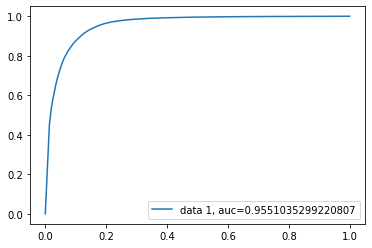

In [60]:
y_pred_proba = rfc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Decision Tree
## Data Cleaning and Transformation

In [14]:
series_pref =pd.Series(pref_list)
series_pref

0         [mysteriesthrillerstruecrime, generalnonfictio...
1                                              [all genres]
2                                              [all genres]
3                              [bookclubpicks, bestsellers]
4                                              [all genres]
                                ...                        
705139                                          [childrens]
705140    [literaryfiction, mysteriesthrillerstruecrime,...
705141    [mysteriesthrillerstruecrime, bestsellers, sci...
705142    [mysteriesthrillerstruecrime, generalnonfictio...
705143                     [childrens, lifestyleandcooking]
Length: 705144, dtype: object

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
new_df = df.join(pd.DataFrame(mlb.fit_transform(series_pref),columns=mlb.classes_))
display (new_df)
print (new_df.info())

#extract the columns of this dataframe in an array to check for column headings
dummie_names2 =new_df.columns.values
dummie_names2

,Profile.Id,Domain,Engagement,Signup,Opens,Clicks,Last.Open,Last.Click,Optout.Time,Geolocation.City,...,young,young adult,younga,youngad,youngadu,youngadul,youngadult,ysteries,ysteriesthrillerstruecrim,ysteriesthrillerstruecrime
0,5572fb5592721912198b587b,sbcglobal.net,hardbounce,2015/06/06 09:53:25,51,11,2016/01/20 00:35:25,2015/08/12 19:50:19,NaN,"El Dorado Hills, CA US",...,0,0,0,0,0,0,0,0,0,0
1,5441111b66dfa5ab01b0a000,hotmail.com,optout,2014/10/17 08:52:43,2,0,2014/11/21 07:37:15,NaN,2014/11/21 07:45:29,NaN,...,0,0,0,0,0,0,0,0,0,0
2,56cde9d9d9cb94486d8b51d7,yahoo.com,optout,2016/02/24 12:35:21,0,0,NaN,NaN,2016/03/02 19:45:14,NaN,...,0,0,0,0,0,0,0,0,0,0
3,57e68298d9cb942a708b48db,gmail.com,dormant,2016/09/24 09:41:44,0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,5498bd77f641910f100e23fb,sbcglobal.net,optout,2014/12/22 19:55:19,30,1,2015/01/06 21:10:26,2015/01/01 21:21:20,2015/01/06 21:11:33,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705139,55b66d8a927219111c8b51b1,gmail.com,disengaged,2015/07/27 13:42:34,11,0,2017/03/10 10:25:29,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
705140,560081500aea1114698b4b55,aol.com,disengaged,2015/09/21 18:14:40,11,1,2017/01/31 11:35:54,2017/01/10 23:00:31,NaN,"Noblesville, IN US",...,0,0,0,0,0,0,0,0,0,0
705141,55ef967599964ad3028b5595,icloud.com,disengaged,2015/09/08 22:16:21,17,0,2017/02/26 10:25:31,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
705142,5741e93c98cb75af508b4760,gmail.com,passive,2016/05/22 13:15:40,225,15,2017/04/17 22:48:54,2016/09/21 16:00:45,NaN,"North Little Rock, AR US",...,0,0,0,0,0,0,1,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705144 entries, 0 to 705143
Columns: 140 entries, Profile.Id to ysteriesthrillerstruecrime
dtypes: float64(1), int32(119), int64(3), object(17)
memory usage: 433.1+ MB
None


array(['Profile.Id', 'Domain', 'Engagement', 'Signup', 'Opens', 'Clicks',
       'Last.Open', 'Last.Click', 'Optout.Time', 'Geolocation.City',
       'Geolocation.State', 'Geolocation.Country', 'Geolocation.Zip',
       'Lifetime.Message', 'Top.Device', 'referral_source', 'first_name',
       'last_name', 'age', 'gender', 'ebb_preferences', '  true crime',
       ' thrillers', ' thrillers  true crime', 'all genres',
       'bestsellers', 'biographiesandmemoi', 'biographiesandmemoir',
       'biography memoir', 'bookclubpicks', 'chil', 'child', 'childr',
       'childre', 'children', 'childrens', 'ciencefictio',
       'ciencefictionfantas', 'estseller', 'estsellers', 'gene', 'gener',
       'genera', 'general', 'general nonfiction', 'generaln', 'generalno',
       'generalnon', 'generalnonf', 'generalnonfi', 'generalnonfic',
       'generalnonfict', 'generalnonficti', 'generalnonfictio',
       'generalnonfiction', 'hildren', 'hist', 'histor',
       'historical fiction', 'historicalfi

In [16]:
new_df['Engagement'] = new_df['Engagement'].replace(['disengaged','active','hardbounce','engaged','new','passive','dormant'], 'subscribed')
print(new_df['Engagement'])



0         subscribed
1             optout
2             optout
3         subscribed
4             optout
             ...    
705139    subscribed
705140    subscribed
705141    subscribed
705142    subscribed
705143    subscribed
Name: Engagement, Length: 705144, dtype: object


In [18]:
#encode non int parameters
new_df, targets = encode_target(new_df, "Geolocation.City")
new_df, targets = encode_target(new_df, "Domain")
df1, targets = encode_target(df1, "Source")
new_df, targets = encode_target(new_df, "Engagement")
new_df, targets = encode_target(new_df, "Top.Device")

In [19]:
#Create X and Y data
features = ["Opens","Clicks","Geolocation.CityEnc","Top.DeviceEnc"]
X = new_df[features]

X = X.join(df1['Signup_Date'].dt.year)
X = X.join(df1['SourceEnc'])

Y = new_df["EngagementEnc"]

#split for train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [20]:
X

,Opens,Clicks,Geolocation.CityEnc,Top.DeviceEnc,Signup_Date,SourceEnc
0,51,11,0,0,2015,0
1,2,0,1,1,2014,1
2,0,0,1,1,2016,0
3,0,0,1,1,2016,2
4,30,1,1,2,2014,3
...,...,...,...,...,...,...
705139,11,0,1,1,2015,0
705140,11,1,573,6,2015,0
705141,17,0,1,1,2015,0
705142,225,15,1896,5,2016,3


## Performing a GridSearch to determine the best parameters for the Decision Tree

In [23]:
#define parameters for gridsearchcv. Class weights not balanced
maxLeafNodes = [100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340]
param_grid = {'max_leaf_nodes': maxLeafNodes}

l = len(maxLeafNodes)
scores = ['accuracy']

testOptAcc = np.zeros(l)
testSubAcc = np.zeros(l)
testMisclass = np.zeros(l)
leafNodes = np.zeros(l)
i = 0


#Create model for each possibility and return an accuracy
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    clf = tree.DecisionTreeClassifier()
    clf = GridSearchCV(clf, param_grid, cv=10)
    clf.fit(X_train, Y_train)
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    
    #loop through parameters
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        clf = tree.DecisionTreeClassifier(max_leaf_nodes=params['max_leaf_nodes'])
        
        #Create model for each parameter set
        clf = clf.fit(X_train, Y_train)
        yPredTest = clf.predict(X_test)
        
        #test accuracy of each parameter set
        testOptAcc[i], testSubAcc[i], testMisclass[i] = accuracy(Y_test, yPredTest)
        leafNodes[i] = params['max_leaf_nodes']
        print('For ', params,'Optout Acc: ', testOptAcc[i]*100,'Sub Acc: ',testSubAcc[i]*100,'Misclass: ', testMisclass[i])
        i+=1
    print()
    

# Tuning hyper-parameters for accuracy

For  {'max_leaf_nodes': 100} Optout Acc:  15.518819665069195 Sub Acc:  95.28399355712278 Misclass:  54416.0
For  {'max_leaf_nodes': 110} Optout Acc:  14.282124459282395 Sub Acc:  95.77362655697519 Misclass:  54342.0
For  {'max_leaf_nodes': 120} Optout Acc:  14.17981440597347 Sub Acc:  95.82303906154745 Misclass:  54322.0
For  {'max_leaf_nodes': 130} Optout Acc:  14.280329546066447 Sub Acc:  95.79351990297181 Misclass:  54312.0
For  {'max_leaf_nodes': 140} Optout Acc:  14.458025954445104 Sub Acc:  95.75630009433296 Misclass:  54271.0
For  {'max_leaf_nodes': 150} Optout Acc:  14.450846301581318 Sub Acc:  95.75822525684876 Misclass:  54272.0
For  {'max_leaf_nodes': 160} Optout Acc:  15.97113779548759 Sub Acc:  95.23073072751892 Misclass:  54247.0
For  {'max_leaf_nodes': 170} Optout Acc:  16.310376393301386 Sub Acc:  95.12227990579538 Misclass:  54227.0
For  {'max_leaf_nodes': 180} Optout Acc:  15.534973884012707 Sub Acc:  95.42966418748516 Misclass:

[54416. 54342. 54322. 54312. 54271. 54272. 54247. 54227. 54180. 54229.
 54235. 54231. 54224. 54210. 54216. 54217. 54227. 54224. 54199. 54195.
 54215. 54204. 54249. 54273. 54303.]


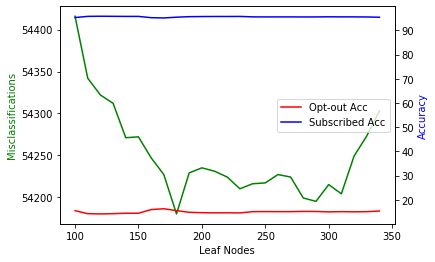

In [24]:
#Unbalanced Plot
fig, ax1 = plt.subplots()
print(testMisclass)

ax2 = ax1.twinx()
ax1.plot(maxLeafNodes, testMisclass, 'g-',label='Misclassifications')
ax2.plot(maxLeafNodes, testOptAcc*100, 'r-',label='Opt-out Acc')
ax2.plot(maxLeafNodes, testSubAcc*100, 'b-',label='Subscribed Acc')

ax1.set_xlabel('Leaf Nodes')
ax1.set_ylabel('Misclassifications', color='g')
ax2.set_ylabel('Accuracy', color='b')
ax2.legend()

plt.show()

In [25]:
#With balanced class weights
maxLeafNodes = [3,4,5,6,7,8,9,10,11,12,13,14,15]
param_grid = {'max_leaf_nodes': maxLeafNodes}

l = len(maxLeafNodes)
scores = ['accuracy']

testOptAcc = np.zeros(l)
testSubAcc = np.zeros(l)
testMisclass = np.zeros(l)
leafNodes = np.zeros(l)
i = 0

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    clf = tree.DecisionTreeClassifier()
    clf = GridSearchCV(clf, param_grid, cv=10)
    clf.fit(X_train, Y_train)
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    
    #loop through parameters
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        clf = tree.DecisionTreeClassifier(max_leaf_nodes=params['max_leaf_nodes'],class_weight="balanced")
        
        #Create model for each parameter set
        clf = clf.fit(X_train, Y_train)
        yPredTest = clf.predict(X_test)
        
        #test accuracy of each parameter set
        testOptAcc[i], testSubAcc[i], testMisclass[i] = accuracy(Y_test, yPredTest)
        leafNodes[i] = params['max_leaf_nodes']
        print('For ', params,'Optout Acc: ', testOptAcc[i]*100,'Sub Acc: ',testSubAcc[i]*100,'Misclass: ', testMisclass[i])
        i+=1
    print()

# Tuning hyper-parameters for accuracy

For  {'max_leaf_nodes': 3} Optout Acc:  89.47642381490854 Sub Acc:  36.527391853995674 Misclass:  104773.0
For  {'max_leaf_nodes': 4} Optout Acc:  69.54391255182813 Sub Acc:  58.64558399804917 Misclass:  81411.0
For  {'max_leaf_nodes': 5} Optout Acc:  60.831403801626195 Sub Acc:  67.55331095866676 Misclass:  72384.0
For  {'max_leaf_nodes': 6} Optout Acc:  60.831403801626195 Sub Acc:  67.55331095866676 Misclass:  72384.0
For  {'max_leaf_nodes': 7} Optout Acc:  68.89774379408755 Sub Acc:  60.83128517432347 Misclass:  78365.0
For  {'max_leaf_nodes': 8} Optout Acc:  69.43980758530324 Sub Acc:  60.47448838806142 Misclass:  78619.0
For  {'max_leaf_nodes': 9} Optout Acc:  67.17821693321127 Sub Acc:  63.89742734115805 Misclass:  74545.0
For  {'max_leaf_nodes': 10} Optout Acc:  67.17821693321127 Sub Acc:  63.89742734115805 Misclass:  74545.0
For  {'max_leaf_nodes': 11} Optout Acc:  67.17821693321127 Sub Acc:  63.89742734115805 Misclass:  74545.0
For  {'ma

[104773.  81411.  72384.  72384.  78365.  78619.  74545.  74545.  74545.
  74545.  74545.  76234.  84703.]


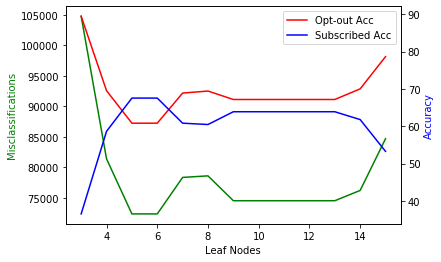

In [26]:
#With balanced class weights
fig, ax1 = plt.subplots()
print(testMisclass)

ax2 = ax1.twinx()
ax1.plot(maxLeafNodes, testMisclass, 'g-',label='Misclassifications')
ax2.plot(maxLeafNodes, testOptAcc*100, 'r-',label='Opt-out Acc')
ax2.plot(maxLeafNodes, testSubAcc*100, 'b-',label='Subscribed Acc')

ax1.set_xlabel('Leaf Nodes')
ax1.set_ylabel('Misclassifications', color='g')
ax2.set_ylabel('Accuracy', color='b')
ax2.legend()

plt.show()

## Training and Testing the Final Model

In [27]:
clf = tree.DecisionTreeClassifier(class_weight ='balanced', max_leaf_nodes = 5)
clf = clf.fit(X_train, Y_train)

yPredTrain = clf.predict(X_train)
yPredTest = clf.predict(X_test)

#receive in and out of sample accuracies from accuracy function
trainOptAcc, trainSubAcc, trainMisclass = accuracy(Y_train, yPredTrain)
testOptAcc, testSubAcc, testMisclass = accuracy(Y_test, yPredTest)

print("Training Opt-out Percent Correct: ",trainOptAcc*100, "\nTraining Subscribed Percent Correct: ", trainSubAcc*100)
print("Test Opt-out Percent Correct: ",testOptAcc*100, "\nTest Subscribed Percent Correct: ", testSubAcc*100, "\nTest Misclassifications: ", testMisclass)

Training Opt-out Percent Correct:  60.9967796350253 
Training Subscribed Percent Correct:  67.51996255300402
Test Opt-out Percent Correct:  60.831403801626195 
Test Subscribed Percent Correct:  67.55331095866676 
Test Misclassifications:  72384


## Plotting the Decision Tree

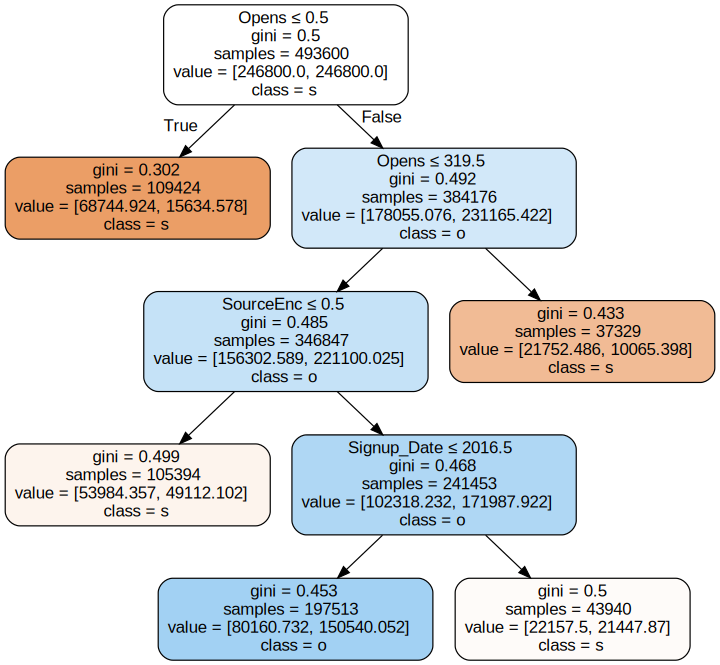

In [28]:
dot_data = export_graphviz(clf, out_file=None,  
                filled=True, rounded=True,
                feature_names=["Opens","Clicks","Geolocation.CityEnc","Top.DeviceEnc","Signup_Date","SourceEnc"],
                class_names="so",
                special_characters=True)

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('original_tree.png')
pydot_graph.set_size('"10,10!"')
pydot_graph.write_png('resized_tree.png')

graph = g.Source(pydot_graph.to_string())    
graph